In [1]:
RESET_PROJECT_FILES = True

if RESET_PROJECT_FILES:
  ! rm -rf DeepColor utils bash &&\
  git clone https://github.com/ArnoBen/DeepColor &&\
  mv DeepColor/* . &&\
  rm -rf DeepColor

Cloning into 'DeepColor'...
remote: Enumerating objects: 199, done.
remote: Counting objects: 100% (62/62), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 199 (delta 32), reused 48 (delta 20), pack-reused 137
Receiving objects: 100% (199/199), 153.54 MiB | 16.97 MiB/s, done.
Resolving deltas: 100% (88/88), done.
Checking out files: 100% (21/21), done.


In [2]:
import os

RESET_IMAGE_FOLDER = False

if RESET_IMAGE_FOLDER:
  ! rm -r images/

if not os.path.isdir('images'):
  ! ./bash/download_extract_coco.sh

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  fonts-droid-fallback fonts-noto-mono ghostscript gsfonts
  imagemagick-6-common imagemagick-6.q16 libcupsfilters1 libcupsimage2
  libdjvulibre-text libdjvulibre21 libgs9 libgs9-common libijs-0.35
  libjbig2dec0 liblqr-1-0 libmagickcore-6.q16-3 libmagickcore-6.q16-3-extra
  libmagickwand-6.q16-3 libnetpbm10 libwmf0.2-7 netpbm poppler-data
Suggested packages:
  fonts-noto ghostscript-x imagemagick-doc autotrace cups-bsd | lpr | lprng
  enscript gimp gnuplot grads hp2xx html2ps libwmf-bin mplayer povray radiance
  sane-utils texlive-base-bin transfig ufraw-batch inkscape libjxr-tools
  libwmf0.2-7-gtk poppler-utils fonts-japanese-mincho | fonts-ipafont-mincho
  fonts-japanese-gothic | fonts-ipafont-goth

In [3]:
import datetime
import tensorflow as tf
import numpy as np
import cv2
from utils.dataset import make_dataset
from utils.conversions import rgb2lab, lab2rgb, bgr2rgb, bgr2lab, denormalize_lab
from utils.decomposition import decompose, recompose, decompose_generator
from keras.callbacks import TensorBoard, LearningRateScheduler, EarlyStopping
from tensorflow.keras.layers import Layer, Conv2D, LeakyReLU, BatchNormalization, ReLU, Conv2DTranspose, Dropout, Concatenate
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams["axes.spines.left"] = False
matplotlib.rcParams["axes.spines.bottom"] = False
matplotlib.rcParams["xtick.major.bottom"] = False
matplotlib.rcParams["ytick.major.left"] = False

# Pix2pix GAN implementation for image colorization

Architecture from [this tensorflow implementation](https://www.tensorflow.org/tutorials/generative/pix2pix) based on the [pix2pix paper](https://arxiv.org/abs/1611.07004).

## EDA and preprocessing

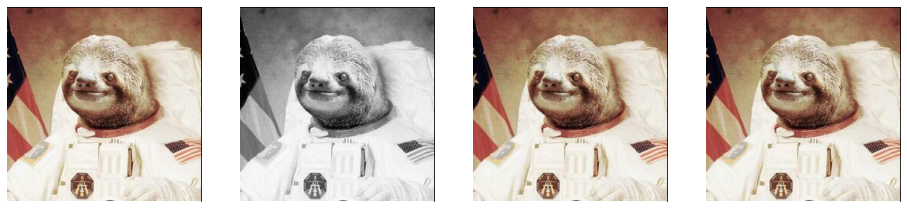

In [4]:
fig, ax = plt.subplots(1, 4, figsize=(16, 5))
img = bgr2rgb(cv2.imread('sloth-256.jpg'))
ax[0].imshow(img);

img = rgb2lab(img)
L, ab = decompose(img)
ax[1].imshow(L[..., 0], cmap='gray');
ax[2].imshow(lab2rgb(img))

recomposed = recompose(L, ab)
ax[3].imshow(lab2rgb(recomposed))

L = tf.cast(L, tf.float32)
ab = tf.cast(ab, tf.float32)

## Generator

### Architecture

In [5]:
OUTPUT_CHANNELS = 2

In [6]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(Conv2D(filters, size, strides=2, padding='same',
                kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(BatchNormalization())

    result.add(LeakyReLU())

    return result

In [7]:
down_model = downsample(3, 4)
down_result = down_model(L[tf.newaxis, ...])
print(down_result.shape)

(1, 128, 128, 3)


In [8]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(Conv2DTranspose(filters, size, strides=2,
                                padding='same',
                                kernel_initializer=initializer,
                                use_bias=False))

    result.add(BatchNormalization())

    if apply_dropout:
        result.add(Dropout(0.5))

    result.add(ReLU())

    return result

In [9]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 3)


In [10]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 1])  # Lightness channel

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = Conv2DTranspose(OUTPUT_CHANNELS, 4,
                          strides=2,
                          padding='same',
                          kernel_initializer=initializer,
                          activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

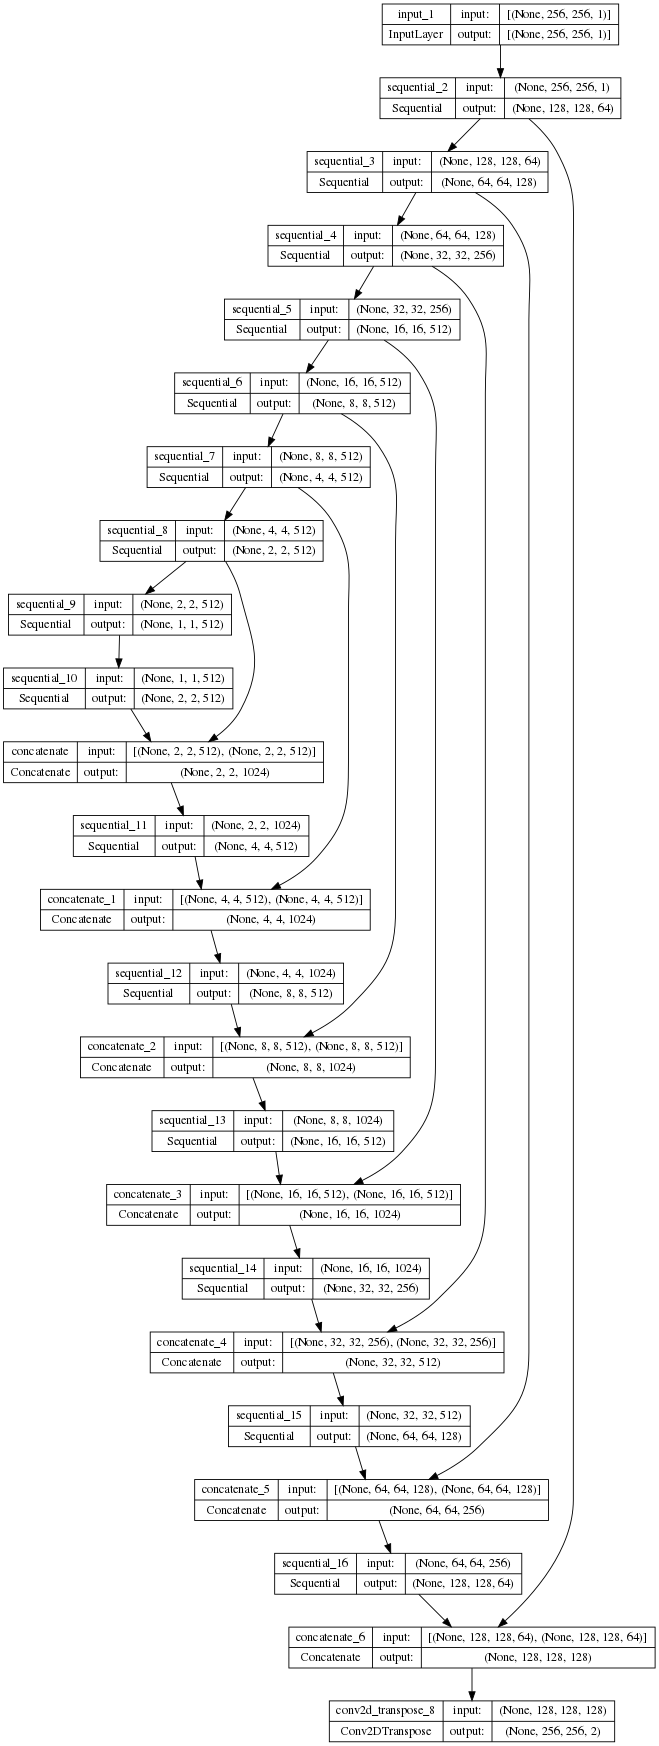

In [11]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

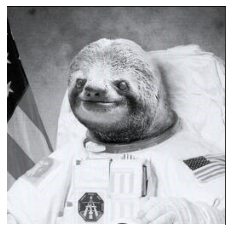

In [12]:
gen_output = generator(L[tf.newaxis, ...], training=False)[0]
gen_lab = recompose(L, gen_output)
gen_output_rgb = lab2rgb(gen_lab)
plt.imshow(gen_output_rgb);

### Loss

GANs learn a loss that adapts to the data, while cGANs learn a structured loss that penalizes a possible structure that differs from the network output and the target image, as described in the pix2pix paper.

- The generator loss is a sigmoid cross-entropy loss of the generated images and an array of ones.
- The pix2pix paper also mentions the L1 loss, which is a MAE (mean absolute error) between the generated image and the target image.
- This allows the generated image to become structurally similar to the target image.
- The formula to calculate the total generator loss is `gan_loss + LAMBDA * l1_loss`, where `LAMBDA = 100`. This value was decided by the authors of the paper.

In [13]:
LAMBDA = 100
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [14]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

## Discriminator

### Architecture

In [15]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

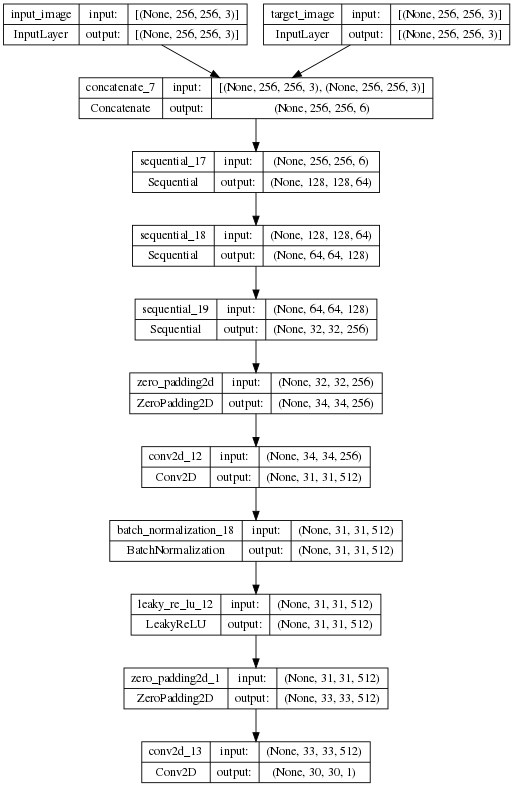

In [16]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

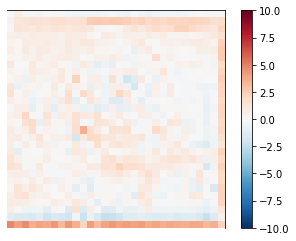

In [17]:
disc_out = discriminator([img[tf.newaxis, ...], gen_lab[tf.newaxis, ...]], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-10, vmax=10, cmap='RdBu_r')
plt.colorbar();

### Loss

In [18]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

## Setting up training

#### Optimizers and checkpoints

In [19]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [20]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### Generate images

Write a function to plot some images during training.

- Pass images from the test set to the generator.
- The generator will then translate the input image into the output.
- The last step is to plot the predictions and voila!

_Note: The training=True is intentional here since you want the batch statistics, while running the model on the test dataset. If you use training=False, you get the accumulated statistics learned from the training dataset (which you don't want)._

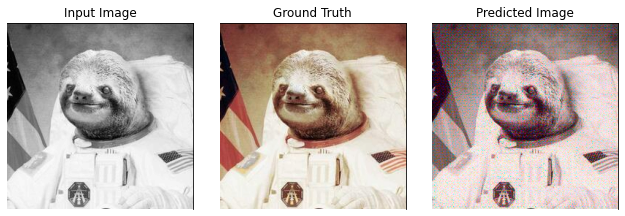

In [58]:
def generate_images(model, target, denormalize=False):
  L, _ = decompose(target)
  L = tf.cast(L, tf.float32)[tf.newaxis, ...]
  prediction = model(L, training=True)
  prediction_lab = recompose(L[0], prediction[0].numpy())
  fig, axes = plt.subplots(1, 3, figsize=(9, 3))
  titles = ['Input Image', 'Ground Truth', 'Predicted Image']

  axes[0].imshow(L[0][..., 0], cmap='gray')
  axes[1].imshow(lab2rgb(target))
  axes[2].imshow(lab2rgb(prediction_lab))

  for i, title in enumerate(titles):
    axes[i].set_title(title)
  plt.tight_layout()
  plt.show()


class GenerateImageCallback(tf.keras.callbacks.Callback):
    def __init__(self, target):
        super(GenerateImageCallback, self).__init__()
        self.target = lab2rgb(target)[tf.newaxis, ...]

    def on_epoch_end(self, epoch, logs=None):
        generate_images(self.model, self.target)


img = bgr2lab(cv2.imread('sloth-256.jpg'))
generate_image_callback = GenerateImageCallback(img)
generate_images(generator, img)

## Training

### Pretraing the generator

In [ ]:
X = make_dataset(train_size=8000, val_size=2000, test_size=100)

Getting all images paths and removing greyscale images


100%|██████████| 100/100 [00:00<00:00, 791.64it/s]


Greyscale images may have been removed, hence the possibly smaller final size

 {'train': 7783, 'valid': 1953, 'test': 98}
Loading data in dictionary and converting to Lab colorspace.


100%|██████████| 98/98 [00:00<00:00, 293.64it/s]


Done.


In [ ]:
# Logs
log_dir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

# Tensorboard
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
# Early Stopping
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

# Learning rate scheduler
def scheduler(epoch, lr):
    # Decreases the lr exponentially every n epoch
    return lr * tf.math.exp(-0.1) if ((epoch != 0) and (epoch % 4 == 0)) else lr
    
lr_scheduler = LearningRateScheduler(scheduler)

In [ ]:
generator = Generator()
BATCH_SIZE = 128
EPOCHS = 20
TRAIN_SIZE, VALID_SIZE = X['train'].shape[0], X['valid'].shape[0]

X_train, X_valid = X['train'][:TRAIN_SIZE], X['valid'][:VALID_SIZE]
steps_per_epoch = X_train.shape[0] // BATCH_SIZE
validation_steps = X_valid.shape[0]


generator.compile(optimizer=generator_optimizer, loss=tf.keras.losses.MeanAbsoluteError())

history = generator.fit(
            decompose_generator(X_train, batch_size=BATCH_SIZE), 
            validation_data=decompose_generator(X_valid), 
            steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
            validation_steps=validation_steps, 
            callbacks=[tensorboard_callback, lr_scheduler, early_stopping, generate_image_callback], 
            verbose=1
        )

# Saving generator weights
best_val_loss_index = np.argmin(history.history['val_loss'])
best_val_loss = history.history['val_loss'][best_val_loss_index]
weights_path = f'weights/weights_gan_{best_val_loss:.4f}'.lower()
generator.save_weights(weights_path)

Epoch 1/20
 6/60 [==>...........................] - ETA: 1:22 - loss: 0.1505

60/60 [==============================] - ETA: 0s - loss: 0.0859

### Training the whole GAN

In [ ]:
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [ ]:
@tf.function
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output_ab = generator(input_image, training=True)
    # Concatenating the ab output with the L channel
    gen_output_lab = tf.concat([input_image, gen_output_ab], axis=-1)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
    tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

## Other tutorial

In [ ]:
class UnetBlock(Layer):
    def __init__(self, nf, ni, submodule=None, input_c=None, dropout=False, innermost=False, outermost=False):
        
        """
        nf: n filters (n input channels)
        ni: n output 
        input_c: 
        dropout (bool): should we add a dropout layer ? (Doesn't apply to innermost and outermost)
        innermost (bool): is it the entry layer
        outermost (bool): is it the exit layer
        """
        super(UnetBlock, self).__init__()
        self.outermost = outermost
        
        if not input_c:
            input_c = nf
        
        downconv = Conv2D(input_c, kernel_size=4, strides=2, padding=1, use_bias=False)

In [ ]:
class UnetBlock(nn.Module):
    def __init__(self, nf, ni, submodule=None, input_c=None, dropout=False,
                 innermost=False, outermost=False):
        super().__init__()
        self.outermost = outermost
        if input_c is None: input_c = nf
        downconv = nn.Conv2d(input_c, ni, kernel_size=4,
                             stride=2, padding=1, bias=False)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = nn.BatchNorm2d(ni)
        uprelu = nn.ReLU(True)
        upnorm = nn.BatchNorm2d(nf)
        
        if outermost:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(ni, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]
            if dropout: up += [nn.Dropout(0.5)]
            model = down + [submodule] + up
        self.model = nn.Sequential(*model)
    
    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:
            return torch.cat([x, self.model(x)], 1)

class Unet(nn.Module):
    def __init__(self, input_c=1, output_c=2, n_down=8, num_filters=64):
        super().__init__()
        unet_block = UnetBlock(num_filters * 8, num_filters * 8, innermost=True)
        for _ in range(n_down - 5):
            unet_block = UnetBlock(num_filters * 8, num_filters * 8, submodule=unet_block, dropout=True)
        out_filters = num_filters * 8
        for _ in range(3):
            unet_block = UnetBlock(out_filters // 2, out_filters, submodule=unet_block)
            out_filters //= 2
        self.model = UnetBlock(output_c, out_filters, input_c=input_c, submodule=unet_block, outermost=True)
    
    def forward(self, x):
        return self.model(x)